In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

## Data Preparation

### Import ASHRAE Global Thermal Comfort Database 2

In [2]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

# Merge building metadata and measurement data
df_rawdata = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')

print('Total buildings:', len(df_rawdata.building_id.unique()))
print('Total records:', len(df_rawdata))

Total buildings: 809
Total records: 109033


/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_39429/1041017263.py:7: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_measurements = pd.read_csv(url_measurements)


### Clean outdoor air temperature data

In [3]:
# Merge two outdoor air temperature columns as a new column
df_rawdata.loc[:, 't_out_combined'] = df_rawdata.loc[:, 't_out_isd'].fillna(df_rawdata.loc[:, 't_out'])

# Remove the two outdoor air temperature columns
df_rawdata = df_rawdata.drop(columns=['t_out_isd', 't_out'])

### A dataframe with each occupant as a row, simultaniouely having Tout, Top, and TSV data

In [4]:
# Keep rows that simultaneously have data for all variables in cols 
def filter(df, cols):
    df_qualifed = df.dropna(subset=cols)
    print(f'Qualified buildings:', len(df_qualifed['building_id'].unique()))
    print(f'Qualified records:', len(df_qualifed))
    return df_qualifed

# Keep rows that simultaneously have data for all variables in cols
cols_1 = ['t_out_combined', 'top', 'set', 'thermal_sensation']
df_data_1 = filter(df_rawdata, cols_1).copy()
df_data_1.head()

Qualified buildings: 518
Qualified records: 26307


,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,ppd,pmv_ce,ppd_ce,t_mot_isd,city,building_type,cooling_type,records,database,t_out_combined
0,0,1,1,1995-05-18T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,10.2,0.38,8.0,17.4,sydney,office,mixed mode,170,1.0,16.295833
1,1,2,1,1995-05-18T00:00:00Z,winter,14.0,NaN,female,NaN,NaN,...,8.4,0.40,8.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
2,2,3,1,1995-05-18T00:00:00Z,winter,15.0,NaN,female,NaN,NaN,...,5.1,-0.07,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833
3,3,4,1,1995-05-18T00:00:00Z,winter,17.0,NaN,female,NaN,NaN,...,7.0,0.14,5.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
4,4,5,1,1995-05-18T00:00:00Z,winter,21.0,NaN,male,NaN,NaN,...,5.0,-0.06,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833


## First stage: neutral temperature estimation

### Define functions for estimating neutral temperature for a building

In [5]:
# regress TSV against Top (metric used in existing AHRAE ACM)
def approach_op_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ top', data=bldg).fit()
        slope = lm_result.params['top']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['top'] < 0.05:
            a = slope
            b = intercept
            temp_n = -b / a
            temp_up = (0.85-b)/a
            temp_low = (-0.85-b)/a
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

# regress Top against TSV  
def approach_op_b(bldg):
    try:
        lm_result = smf.ols(formula='top ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['thermal_sensation'] < 0.05:
            a = slope
            b = intercept
            temp_n = b
            temp_up = 0.85*a + b
            temp_low = (-0.85)*a + b
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan
    
# regress TSV against SET (a new metric)
def approach_SET_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ set', data=bldg).fit()
        slope = lm_result.params['set']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['set'] < 0.05:
            a = slope
            b = intercept
            temp_n = -b / a
            temp_up = (0.85-b)/a
            temp_low = (-0.85-b)/a
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

# regress SET against TSV  
def approach_SET_b(bldg):
    try:
        lm_result = smf.ols(formula='set ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['thermal_sensation'] < 0.05:
            a = slope
            b = intercept
            temp_n = b
            temp_up = 0.85*a + b
            temp_low = (-0.85)*a + b
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

### A dataframe with each building as a row, to store the first stage result

In [6]:
# Define the columns for which you want to calculate the mean
mean_cols = ['t_out_combined']

# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data_1.groupby('building_id')[mean_cols].mean()

# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)

# Merge df_means with the metadata
df_bldg_1 = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type', 'database']], on='building_id', how='left')

# Reset the building cooling type as string
df_bldg_1['cooling_type'] = df_bldg_1['cooling_type'].str.title()

### Estimate neutral temperature (top) for each single building

In [7]:
# store regression results as columns
columns_name = ['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low']

# calculate regression results for each building
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg_1[column] = df_data_1.groupby('building_id').apply(lambda x: approach_op_a(x)[i] if approach_op_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg_1[column] = df_data_1.groupby('building_id').apply(lambda x: approach_op_b(x)[i] if approach_op_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

df_bldg_1.head()

,building_id,t_out_combined,records,cooling_type,building_type,database,slope_a,slope_b,intercept_a,intercept_b,temp_n_a,temp_n_b,temp_up_a,temp_up_b,temp_low_a,temp_low_b
0,1,15.560695,170,Mixed Mode,office,1.0,0.282810,0.708579,-5.944612,22.891465,21.019827,22.891465,24.025381,23.493757,18.014273,22.289173
1,2,13.995833,83,Air Conditioned,office,1.0,0.643948,0.292102,-14.358447,22.322748,22.297532,22.322748,23.617515,22.571035,20.977549,22.074462
2,3,0.583480,85,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,19.225391,137,Mixed Mode,office,1.0,0.478756,0.462422,-11.383983,23.901268,23.778269,23.901268,25.553704,24.294327,22.002833,23.508209
4,5,9.048210,128,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Second stage: ACM

### Filter out non-signficant regression results

In [8]:
# number of all buildings
print('Total buildings:', len(df_bldg_1))
print("Total NV buildings:", len(df_bldg_1[df_bldg_1['cooling_type'] == 'Naturally Ventilated']))
print("Total AC buildings:", len(df_bldg_1[df_bldg_1['cooling_type'] == 'Air Conditioned']))

# get rid of all nan values in the temp_n_a column
df_bldg_1_sig_a = df_bldg_1[~df_bldg_1['temp_n_a'].isna()]
# print("******************************************************************************")
# # print the number of buildings that have negative slopes
# print('Total negative signifiant buildings:', df_bldg_1[df_bldg_1['slope_a']<0].building_id.nunique())


df_bldg_1_NV_a = df_bldg_1_sig_a[df_bldg_1_sig_a['cooling_type'] == 'Naturally Ventilated']
df_bldg_1_AC_a = df_bldg_1_sig_a[df_bldg_1_sig_a['cooling_type'] == 'Air Conditioned']
df_bldg_1_office_NV_a = df_bldg_1_NV_a[df_bldg_1_NV_a['building_type'] == 'office'].copy()
df_bldg_1_office_AC_a = df_bldg_1_AC_a[df_bldg_1_AC_a['building_type'] == 'office'].copy()

print("******************************************************************************")
print('Approach (a)')
print('Total signficant buildings:', len(df_bldg_1_sig_a))
print('Total signficant NV buildings:', len(df_bldg_1_NV_a))
print('Total signficant NV office buildings:', len(df_bldg_1_office_NV_a))
print('Total signficant AC buildings:', len(df_bldg_1_AC_a))
print('Total signficant AC office buildings:', len(df_bldg_1_office_AC_a))

# get rid of all nan values in the temp_n_a column
df_bldg_1_sig_b = df_bldg_1[~df_bldg_1['temp_n_b'].isna()]
df_bldg_1_NV_b = df_bldg_1_sig_b[df_bldg_1_sig_b['cooling_type'] == 'Naturally Ventilated']
df_bldg_1_AC_b = df_bldg_1_sig_b[df_bldg_1_sig_b['cooling_type'] == 'Air Conditioned']
df_bldg_1_office_AC_b = df_bldg_1_AC_b[df_bldg_1_AC_b['building_type'] == 'office'].copy()
df_bldg_1_office_NV_b = df_bldg_1_NV_b[df_bldg_1_NV_b['building_type'] == 'office'].copy()

print("******************************************************************************")
print('Approach (b)')
print('Total signficant buildings:', len(df_bldg_1_sig_b))
print('Total signficant NV buildings:', len(df_bldg_1_NV_b))
print('Total signficant NV office buildings:', len(df_bldg_1_office_NV_b))
print('Total signficant AC buildings:', len(df_bldg_1_AC_b))
print('Total signficant AC office buildings:', len(df_bldg_1_office_AC_b))

Total buildings: 518
Total NV buildings: 197
Total AC buildings: 153
******************************************************************************
Approach (a)
Total signficant buildings: 184
Total signficant NV buildings: 61
Total signficant NV office buildings: 41
Total signficant AC buildings: 74
Total signficant AC office buildings: 74
******************************************************************************
Approach (b)
Total signficant buildings: 198
Total signficant NV buildings: 67
Total signficant NV office buildings: 41
Total signficant AC buildings: 74
Total signficant AC office buildings: 74


### Define a weighted linear regression

In [9]:
# Weighted regression function
def weighted_regression(x, y, weights):
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()
    intercept, slope = model.params
    print('p value {:.3f}'.format(model.pvalues[1]))
    print(model.summary())
    return intercept, slope

### ACM (op) for all NV offices

In [37]:
# only keep buildings with 10 < t_out_combined < 33.5
df_ACM_op_NV_a = df_bldg_1_office_NV_a[(df_bldg_1_office_NV_a['t_out_combined'] >= 10) & (df_bldg_1_office_NV_a['t_out_combined'] <= 33.5)]
df_ACM_op_NV_b = df_bldg_1_office_NV_b[(df_bldg_1_office_NV_b['t_out_combined'] >= 10) & (df_bldg_1_office_NV_b['t_out_combined'] <= 33.5)]
print("Total buildings for Approach (a) ACM_NV:", len(df_ACM_op_NV_a))
print("Total buildings for Approach (b) ACM_NV:", len(df_ACM_op_NV_b))

Total buildings for Approach (a) ACM_NV: 39
Total buildings for Approach (b) ACM_NV: 39


#### Approach (a)

In [38]:
# conduct weighted ACM regression line based on approach (a)
temp_n_a_intercept, temp_n_a_slope = weighted_regression(df_ACM_op_NV_a['t_out_combined'], df_ACM_op_NV_a['temp_n_a'], df_ACM_op_NV_a['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(temp_n_a_slope))
print('ACM regression line slope: {:.2f}'.format(temp_n_a_intercept))

# calculate the mean comfort zone
range_a = df_ACM_op_NV_a['temp_up_a'].mean() - df_ACM_op_NV_a['temp_low_a'].mean()
print('ACM comfort zone: {:.2f}'.format(range_a))

p value 0.000
                            WLS Regression Results                            
Dep. Variable:               temp_n_a   R-squared:                       0.407
Model:                            WLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     25.35
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           1.27e-05
Time:                        16:19:16   Log-Likelihood:                -83.089
No. Observations:                  39   AIC:                             170.2
Df Residuals:                      37   BIC:                             173.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.3442     

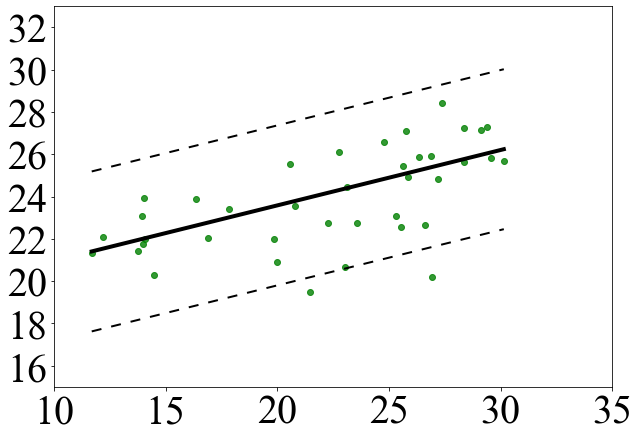

In [39]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_op_NV_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept + range_a/2
low_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept - range_a/2
middle_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_op_NV_a, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(15, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_NV_neutral_a.pdf', format='pdf', bbox_inches='tight')


#### Approach (b)

In [13]:
# conduct weighted ACM_NV regression line based on approach (b)
temp_n_b_intercept, temp_n_b_slope = weighted_regression(df_ACM_op_NV_b['t_out_combined'], df_ACM_op_NV_b['temp_n_b'], df_ACM_op_NV_b['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM_NV regression line slope: {:.2f}'.format(temp_n_b_slope))
print('ACM_NV regression line slope: {:.2f}'.format(temp_n_b_intercept))

# calculate the mean comfort zone
range_b = df_ACM_op_NV_b['temp_up_b'].mean() - df_ACM_op_NV_b['temp_low_b'].mean()
print('ACM_NV comfort zone: {:.2f}'.format(range_b))

p value 0.000
                            WLS Regression Results                            
Dep. Variable:               temp_n_b   R-squared:                       0.835
Model:                            WLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     187.4
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           4.67e-16
Time:                        15:26:18   Log-Likelihood:                -73.198
No. Observations:                  39   AIC:                             150.4
Df Residuals:                      37   BIC:                             153.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.5774     

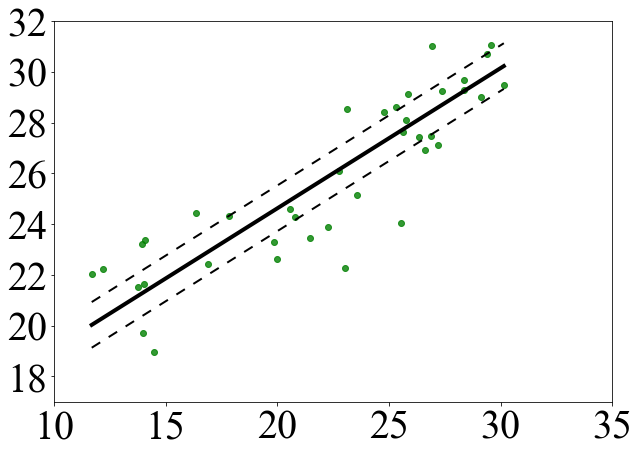

In [14]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_op_NV_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept + range_b/2
low_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept - range_b/2
middle_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_b', data=df_ACM_op_NV_b, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 32)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_NV_neutral_b.pdf', format='pdf', bbox_inches='tight')

## Use a new metric SET to represent the indoor temperature

In [286]:
# # Keep rows that simultaneously have data for all variables in cols
# cols_2 = ['t_out_combined', 'set','thermal_sensation']
# df_data_2 = filter(df_rawdata, cols_2).copy()

# # Define the columns for which you want to calculate the mean
# mean_cols = ['t_out_combined']
# # Group by 'building_id' and calculate the mean for all these columns at once
# df_means = df_data_2.groupby('building_id')[mean_cols].mean()
# # Reset the index of df_means to make 'building_id' a column again
# df_means.reset_index(inplace=True)

### A new dataframe with each building as a row

In [15]:
df_data_2 = df_data_1

# Define the columns for which you want to calculate the mean
mean_cols = ['t_out_combined']

# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data_2.groupby('building_id')[mean_cols].mean()

# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)

# Merge df_means with the metadata
df_bldg_2 = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type', 'database']], on='building_id', how='left')

# Reset the building cooling type as string
df_bldg_2['cooling_type'] = df_bldg_2['cooling_type'].str.title()

### Estimate neutral temperature (SET) for each single building

In [16]:
# store regression results as columns
columns_name = ['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low']

# calculate regression results for each building
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg_2[column] = df_data_2.groupby('building_id').apply(lambda x: approach_SET_a(x)[i] if approach_SET_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg_2[column] = df_data_2.groupby('building_id').apply(lambda x: approach_SET_b(x)[i] if approach_SET_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

df_bldg_2.head()

,building_id,t_out_combined,records,cooling_type,building_type,database,slope_a,slope_b,intercept_a,intercept_b,temp_n_a,temp_n_b,temp_up_a,temp_up_b,temp_low_a,temp_low_b
0,1,15.560695,170,Mixed Mode,office,1.0,0.291385,0.872775,-6.755008,24.876473,23.182414,24.876473,26.099516,25.618332,20.265312,24.134614
1,2,13.995833,83,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.583480,85,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,19.225391,137,Mixed Mode,office,1.0,0.211156,0.483831,-5.026896,24.128114,23.806534,24.128114,27.831991,24.539370,19.781077,23.716858
4,5,9.048210,128,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filter out non-significant regression results

In [17]:
# number of all buildings
print('Total buildings:', len(df_bldg_2))
print("Total NV buildings:", len(df_bldg_2[df_bldg_2['cooling_type'] == 'Naturally Ventilated']))
print("Total AC buildings:", len(df_bldg_2[df_bldg_2['cooling_type'] == 'Air Conditioned']))

# get rid of all nan values in the temp_n_a column
df_bldg_2_sig_a = df_bldg_2[~df_bldg_2['temp_n_a'].isna()]
df_bldg_2_NV_a = df_bldg_2_sig_a[df_bldg_2_sig_a['cooling_type'] == 'Naturally Ventilated']
df_bldg_2_AC_a = df_bldg_2_sig_a[df_bldg_2_sig_a['cooling_type'] == 'Air Conditioned']
df_bldg_2_office_NV_a = df_bldg_2_NV_a[df_bldg_2_NV_a['building_type'] == 'office'].copy()
df_bldg_2_office_AC_a = df_bldg_2_AC_a[df_bldg_2_AC_a['building_type'] == 'office'].copy()

print("******************************************************************************")
print('Approach (a)')
print('Total signficant buildings:', len(df_bldg_2_sig_a))
print('Total signficant NV buildings:', len(df_bldg_2_NV_a))
print('Total signficant NV office buildings:', len(df_bldg_2_office_NV_a))
print('Total signficant AC buildings:', len(df_bldg_2_AC_a))
print('Total signficant AC office buildings:', len(df_bldg_2_office_AC_a))


# get rid of all nan values in the temp_n_a column
df_bldg_2_sig_b = df_bldg_2[~df_bldg_2['temp_n_b'].isna()]
df_bldg_2_NV_b = df_bldg_2_sig_b[df_bldg_2_sig_b['cooling_type'] == 'Naturally Ventilated']
df_bldg_2_AC_b = df_bldg_2_sig_b[df_bldg_2_sig_b['cooling_type'] == 'Air Conditioned']
df_bldg_2_office_AC_b = df_bldg_2_AC_b[df_bldg_2_AC_b['building_type'] == 'office'].copy()
df_bldg_2_office_NV_b = df_bldg_2_NV_b[df_bldg_2_NV_b['building_type'] == 'office'].copy()

print("******************************************************************************")
print('Approach (b)')
print('Total signficant buildings:', len(df_bldg_2_sig_b))
print('Total signficant NV buildings:', len(df_bldg_2_NV_b))
print('Total signficant NV office buildings:', len(df_bldg_2_office_NV_b))
print('Total signficant AC buildings:', len(df_bldg_2_AC_b))
print('Total signficant AC office buildings:', len(df_bldg_2_office_AC_b))

Total buildings: 518
Total NV buildings: 197
Total AC buildings: 153
******************************************************************************
Approach (a)
Total signficant buildings: 135
Total signficant NV buildings: 58
Total signficant NV office buildings: 35
Total signficant AC buildings: 39
Total signficant AC office buildings: 39
******************************************************************************
Approach (b)
Total signficant buildings: 144
Total signficant NV buildings: 64
Total signficant NV office buildings: 35
Total signficant AC buildings: 39
Total signficant AC office buildings: 39


### ACM (SET) for all NV offices

In [18]:
# only keep buildings with 10 < t_out_combined < 33.5
df_ACM_SET_NV_a = df_bldg_2_office_NV_a[(df_bldg_2_office_NV_a['t_out_combined'] >= 10) & (df_bldg_2_office_NV_a['t_out_combined'] <= 33.5)]
df_ACM_SET_NV_b = df_bldg_2_office_NV_b[(df_bldg_2_office_NV_b['t_out_combined'] >= 10) & (df_bldg_2_office_NV_b['t_out_combined'] <= 33.5)]
print("Total buildings for Approach (a) ACM_NV:", len(df_ACM_SET_NV_a))
print("Total buildings for Approach (b) ACM_NV:", len(df_ACM_SET_NV_b))

Total buildings for Approach (a) ACM_NV: 34
Total buildings for Approach (b) ACM_NV: 34


####  Approach (a)

In [19]:
# conduct weighted ACM regression line based on approach (a)
temp_n_a_intercept, temp_n_a_slope = weighted_regression(df_ACM_SET_NV_a['t_out_combined'], df_ACM_SET_NV_a['temp_n_a'], df_ACM_SET_NV_a['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(temp_n_a_slope))
print('ACM regression line slope: {:.2f}'.format(temp_n_a_intercept))

# calculate the mean comfort zone
range_a = df_ACM_SET_NV_a['temp_up_a'].mean() - df_ACM_SET_NV_a['temp_low_a'].mean()
print('ACM comfort zone: {:.2f}'.format(range_a))

p value 0.357
                            WLS Regression Results                            
Dep. Variable:               temp_n_a   R-squared:                       0.027
Model:                            WLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8736
Date:                Tue, 09 Jan 2024   Prob (F-statistic):              0.357
Time:                        15:26:59   Log-Likelihood:                -100.02
No. Observations:                  34   AIC:                             204.0
Df Residuals:                      32   BIC:                             207.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             26.6438     

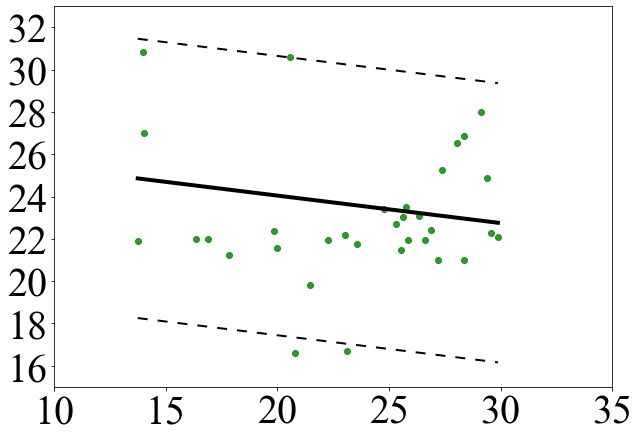

In [20]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_SET_NV_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept + range_a/2
low_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept - range_a/2
middle_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_SET_NV_a, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(15, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_NV_neutral_a.pdf', format='pdf', bbox_inches='tight')

In [21]:
# building id where t_out_combined <15
df_ACM_SET_NV_a[df_ACM_SET_NV_a['t_out_combined'] < 15].building_id.unique()

array([176, 181, 182])

#### Approach (b)

In [32]:
# conduct weighted ACM_NV regression line based on approach (b)
temp_n_b_intercept, temp_n_b_slope = weighted_regression(df_ACM_SET_NV_b['t_out_combined'], df_ACM_SET_NV_b['temp_n_b'], df_ACM_SET_NV_b['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM_NV regression line slope: {:.2f}'.format(temp_n_b_slope))
print('ACM_NV regression line slope: {:.2f}'.format(temp_n_b_intercept))

# calculate the mean comfort zone
range_b = df_ACM_SET_NV_b['temp_up_b'].mean() - df_ACM_SET_NV_b['temp_low_b'].mean()
print('ACM_NV comfort zone: {:.2f}'.format(range_b))

p value 0.000
                            WLS Regression Results                            
Dep. Variable:               temp_n_b   R-squared:                       0.715
Model:                            WLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     80.16
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           3.16e-10
Time:                        16:14:24   Log-Likelihood:                -63.432
No. Observations:                  34   AIC:                             130.9
Df Residuals:                      32   BIC:                             133.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.1107     

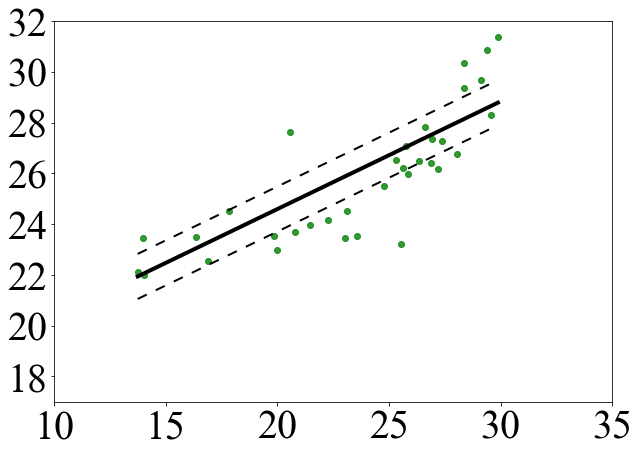

In [33]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_SET_NV_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept + range_b/2
low_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept - range_b/2
middle_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_b', data=df_ACM_SET_NV_b, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 32)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_NV_neutral_b.pdf', format='pdf', bbox_inches='tight')

In [34]:
# building id where t_out_combined <15
df_ACM_SET_NV_b[df_ACM_SET_NV_b['t_out_combined'] < 15].building_id.unique()

array([176, 181, 182])

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

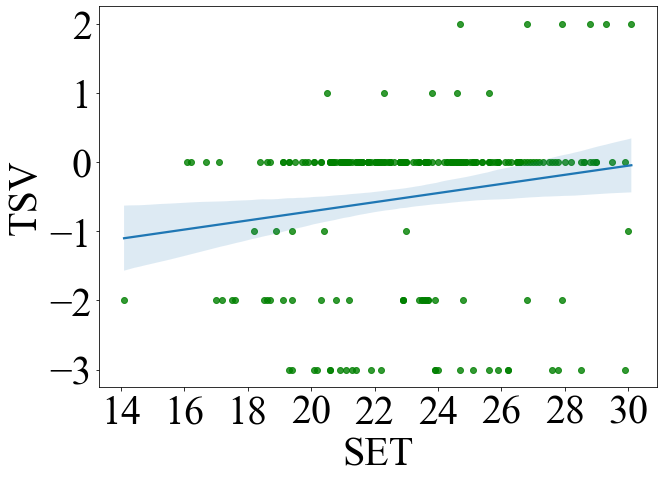

In [35]:
# plot linear regression for building 176 between thermal sensation and set
plt.figure(figsize=(10, 7))
sns.regplot(x='set', y='thermal_sensation', data=df_data_2[df_data_2.building_id == 176], fit_reg=True, scatter_kws={'color': 'green'})
plt.xlabel('SET', fontsize=40)
plt.ylabel('TSV', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

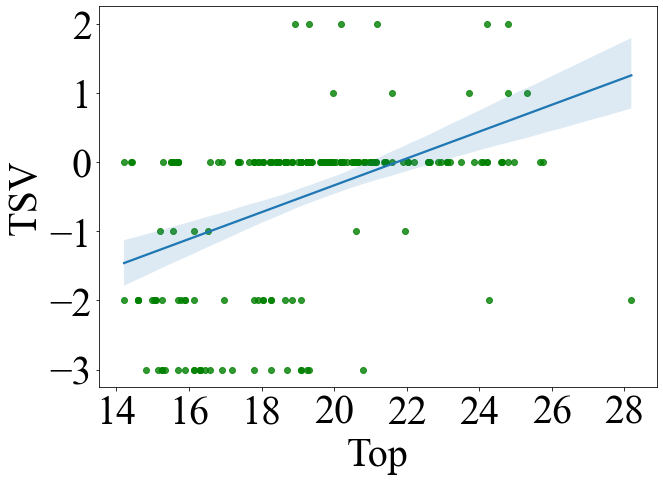

In [41]:
# plot linear regression for building 176 between thermal sensation and set
plt.figure(figsize=(10, 7))
sns.regplot(x='top', y='thermal_sensation', data=df_data_2[df_data_2.building_id == 176], fit_reg=True, scatter_kws={'color': 'green'})
plt.xlabel('Top', fontsize=40)
plt.ylabel('TSV', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

(array([12., 14., 16., 18., 20., 22., 24., 26., 28., 30., 32.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

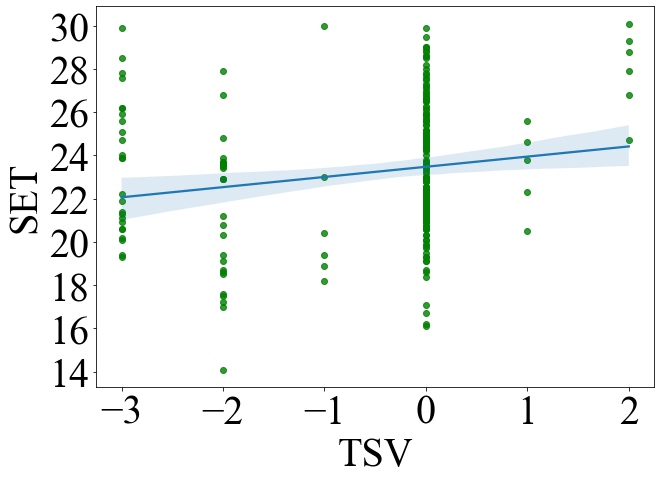

In [36]:
# plot linear regression for building 176 between thermal sensation and set
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='set', data=df_data_2[df_data_2.building_id == 176], fit_reg=True, scatter_kws={'color': 'green'})
plt.xlabel('TSV', fontsize=40)
plt.ylabel('SET', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

## ACM (SET) for all AC offices

In [26]:
# only keep buildings with 10 < t_out_combined < 33.5
df_ACM_SET_AC_a = df_bldg_2_office_AC_a[(df_bldg_2_office_AC_a['t_out_combined'] >= 10) & (df_bldg_2_office_AC_a['t_out_combined'] <= 33.5)]
df_ACM_SET_AC_b = df_bldg_2_office_AC_b[(df_bldg_2_office_AC_b['t_out_combined'] >= 10) & (df_bldg_2_office_AC_b['t_out_combined'] <= 33.5)]
print("Total buildings for Approach (a) ACM_AC:", len(df_ACM_SET_AC_a))
print("Total buildings for Approach (b) ACM_AC:", len(df_ACM_SET_AC_b))

Total buildings for Approach (a) ACM_AC: 34
Total buildings for Approach (b) ACM_AC: 34


Approach (a)

In [27]:
# conduct weighted ACM regression line based on approach (a)
temp_n_a_intercept, temp_n_a_slope = weighted_regression(df_ACM_SET_AC_a['t_out_combined'], df_ACM_SET_AC_a['temp_n_a'], df_ACM_SET_AC_a['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(temp_n_a_slope))
print('ACM regression line slope: {:.2f}'.format(temp_n_a_intercept))

# calculate the mean comfort zone
range_a = df_ACM_SET_AC_a['temp_up_a'].mean() - df_ACM_SET_AC_a['temp_low_a'].mean()
print('ACM comfort zone: {:.2f}'.format(range_a))

p value 0.002
                            WLS Regression Results                            
Dep. Variable:               temp_n_a   R-squared:                       0.272
Model:                            WLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     11.93
Date:                Tue, 09 Jan 2024   Prob (F-statistic):            0.00158
Time:                        15:29:00   Log-Likelihood:                -76.503
No. Observations:                  34   AIC:                             157.0
Df Residuals:                      32   BIC:                             160.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.5132     

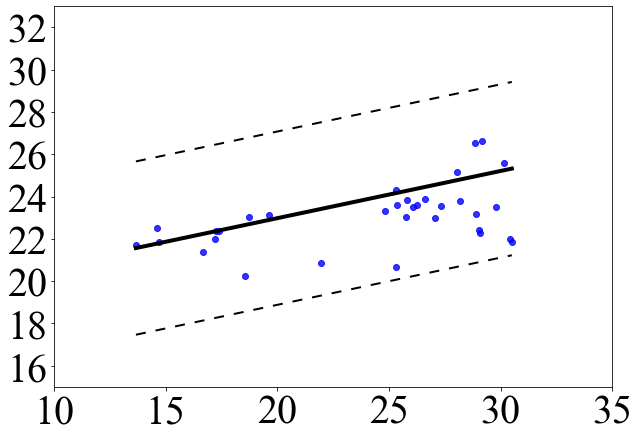

In [29]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_SET_AC_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept + range_a/2
low_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept - range_a/2
middle_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_SET_AC_a, fit_reg=False, scatter_kws={'color': 'blue'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(15, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_NV_neutral_a.pdf', format='pdf', bbox_inches='tight')

Approach (b)

In [30]:
# conduct weighted ACM_AC regression line based on approach (b)
temp_n_b_intercept, temp_n_b_slope = weighted_regression(df_ACM_SET_AC_b['t_out_combined'], df_ACM_SET_AC_b['temp_n_b'], df_ACM_SET_AC_b['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM_AC regression line slope: {:.2f}'.format(temp_n_b_slope))
print('ACM_AC regression line slope: {:.2f}'.format(temp_n_b_intercept))

# calculate the mean comfort zone
range_b = df_ACM_SET_AC_b['temp_up_b'].mean() - df_ACM_SET_AC_b['temp_low_b'].mean()
print('ACM_AC comfort zone: {:.2f}'.format(range_b))

p value 0.227
                            WLS Regression Results                            
Dep. Variable:               temp_n_b   R-squared:                       0.045
Model:                            WLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.517
Date:                Tue, 09 Jan 2024   Prob (F-statistic):              0.227
Time:                        15:30:07   Log-Likelihood:                -47.522
No. Observations:                  34   AIC:                             99.04
Df Residuals:                      32   BIC:                             102.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.7922     

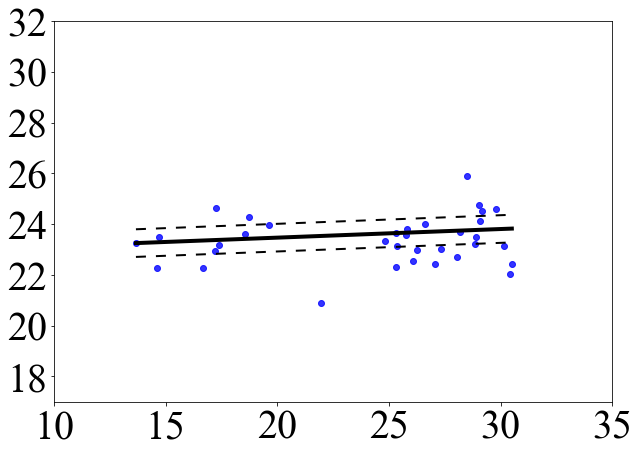

In [31]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_SET_AC_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept + range_b/2
low_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept - range_b/2
middle_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_b', data=df_ACM_SET_AC_b, fit_reg=False, scatter_kws={'color': 'blue'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 32)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_AC_neutral_b.pdf', format='pdf', bbox_inches='tight')

## PMV

In [150]:
# check nan values in columns of df_data_1: ta, rh, vel, tr, met, clo
print(df_data_1['ta'].isna().sum())
print(df_data_1['rh'].isna().sum())
print(df_data_1['vel'].isna().sum())
print(df_data_1['tr'].isna().sum())
print(df_data_1['met'].isna().sum())
print(df_data_1['clo'].isna().sum())


0
0
0
0
0
0
